In [11]:
from Triangulation import *

import torch
import torch.optim as optim



from matplotlib import pyplot as plt

import torch.nn as nn
from torch.autograd import Variable

from  Neural_network import *

%matplotlib qt


In [222]:
def get_set_nb_of_points(point_coordinates):
    set_of_numbers=set()
    for index,_ in enumerate(point_coordinates):
        set_of_numbers.add(len(point_coordinates[index][0]))
    return set_of_numbers


def get_indices_nb_of_points(set_of_numbers,number_of_points,point_coordinates):
    indices=[]
    if number_of_points not in set_of_numbers:
        return "No such number of points for sample"
    else:
        for index,_ in enumerate(point_coordinates):
            if len(point_coordinates[index][0])==number_of_points:
                indices.append(index)
        return indices
    
def get_polygons_nb_of_points(indices):
    pass



In [224]:
polygons=load_dataset('12_polygons.pkl')
polygons=[i for i in polygons for j in range(10)]
polygons_reshaped=[]
for polygon in polygons:
    polygons_reshaped.append(polygon.reshape(2,12))

polygons_reshaped=np.array(polygons_reshaped)
#polygons_reshaped=polygons_reshaped.reshape(60000,24)

In [225]:
point_coordinates=load_dataset('12_point_coordinates')
number_of_insertion_points=load_dataset('12_nb_of_points.pkl')
centers_of_mass=load_dataset('12_centers_of_mass')

In [226]:
set_of_points=get_set_nb_of_points(point_coordinates)        
indices=get_indices_nb_of_points(set_of_points,1,point_coordinates)
indices=np.asarray(indices)
number_of_insertion_points=np.array(number_of_insertion_points)

In [228]:
polygons_reshaped.resize(len(point_coordinates),2*12)

polygons_reshaped=np.hstack([polygons_reshaped[indices],number_of_insertion_points[indices,1].reshape(len(indices),1) ])
#polygons_reshaped=polygons_reshaped[indices]


In [229]:
point_coordinates=[ point_coordinates[i][0] for i in indices]
point_coordinates=np.array(point_coordinates)
#barycenters,point_coordinates

In [230]:
#len(polygons_reshaped),len(indices)
#point_coordinates.shape
centers_of_mass=centers_of_mass.reshape(60000,2)

In [231]:
nb_of_test_data=int(len(polygons_reshaped)*0.2)
nb_of_training_data=int(len(polygons_reshaped)-nb_of_test_data)


In [232]:
x_tensor=torch.from_numpy(polygons_reshaped[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)

y_tensor=torch.from_numpy(point_coordinates[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(point_coordinates[nb_of_training_data:]).type(torch.FloatTensor)
y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)



shuffle=torch.randperm(x_variable.shape[0])
x_variable = x_variable[shuffle]
y_variable=y_variable[shuffle]

In [233]:
my_net=Net(2*12+1,1*2,nb_of_hidden_layers=2, nb_of_hidden_nodes=40,batch_normalization=True)
print("Training data length:",x_variable.size()[0])

Training data length: 174978


In [234]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3,weight_decay=0)
#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)
max_distance=0.6108970818704328
loss_func =torch.nn.MSELoss(size_average=False) 
#loss_func=myLossfunction()


In [235]:
if  torch.cuda.is_available():
    loss_func.cuda()
    x_variable , y_variable=x_variable.cuda(), y_variable.cuda()
    x_variable_test,y_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_test.cuda(),volatile=True)
    print("cuda activated")


cuda activated


In [286]:
batch_size=int(x_variable.size()[0]/2 )
nb_of_epochs=13000
my_net.cuda()

# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        #loss=loss_func.apply(out, y_variable.narrow(0,b,batch_size).resize(batch_size,2))

        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_net.eval()
        test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
        my_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 0.03597994311472371 Test Loss: 0.04591718449065872
Epoch: 10 Training Loss: 0.03595471533385625 Test Loss: 0.04589256057795069
Epoch: 20 Training Loss: 0.03594138357973931 Test Loss: 0.04591361257222419
Epoch: 30 Training Loss: 0.03593050609621281 Test Loss: 0.045934031109087815
Epoch: 40 Training Loss: 0.03591936490765982 Test Loss: 0.04592797838167806
Epoch: 50 Training Loss: 0.03590778560599404 Test Loss: 0.045925185029839805
Epoch: 60 Training Loss: 0.03589508590678185 Test Loss: 0.04591705891540126
Epoch: 70 Training Loss: 0.03588216156995451 Test Loss: 0.04591509994138482
Epoch: 80 Training Loss: 0.035868235433079446 Test Loss: 0.0459132721237484
Epoch: 90 Training Loss: 0.03585296007524875 Test Loss: 0.045934519457311286
Epoch: 100 Training Loss: 0.03583402354287039 Test Loss: 0.04594240000235746
Epoch: 110 Training Loss: 0.03581583068657203 Test Loss: 0.045958989889149086
Epoch: 120 Training Loss: 0.03579958701504618 Test Loss: 0.04595384130359306
Epoch:

Epoch: 1060 Training Loss: 0.03479608893019765 Test Loss: 0.04567305502790383
Epoch: 1070 Training Loss: 0.03479582522517116 Test Loss: 0.04566230299530364
Epoch: 1080 Training Loss: 0.03479010324467576 Test Loss: 0.04565334808416583
Epoch: 1090 Training Loss: 0.03478691366959347 Test Loss: 0.04566559027648792
Epoch: 1100 Training Loss: 0.034785057967555204 Test Loss: 0.045671444874047014
Epoch: 1110 Training Loss: 0.03478078427180845 Test Loss: 0.04569929188502995
Epoch: 1120 Training Loss: 0.03477596502756775 Test Loss: 0.04563707353079851
Epoch: 1130 Training Loss: 0.034769966784663646 Test Loss: 0.045642827668151635
Epoch: 1140 Training Loss: 0.03476319696038573 Test Loss: 0.045653063446915575
Epoch: 1150 Training Loss: 0.03475804006208995 Test Loss: 0.045649285026946554
Epoch: 1160 Training Loss: 0.03475350963764016 Test Loss: 0.045658156221246055
Epoch: 1170 Training Loss: 0.034749255475599074 Test Loss: 0.04565039287977351
Epoch: 1180 Training Loss: 0.03474601567098792 Test Loss

Epoch: 2110 Training Loss: 0.034437557529553714 Test Loss: 0.045813699316263376
Epoch: 2120 Training Loss: 0.03443457724417498 Test Loss: 0.045873674059228126
Epoch: 2130 Training Loss: 0.03443274805216585 Test Loss: 0.045869750530072695
Epoch: 2140 Training Loss: 0.034430712360982524 Test Loss: 0.04583919109352854
Epoch: 2150 Training Loss: 0.03442982357737473 Test Loss: 0.04591335584058671
Epoch: 2160 Training Loss: 0.03443050167601427 Test Loss: 0.04585688604258584
Epoch: 2170 Training Loss: 0.03442687677834856 Test Loss: 0.045893743775932125
Epoch: 2180 Training Loss: 0.034425199670190684 Test Loss: 0.04588032396675115
Epoch: 2190 Training Loss: 0.03442803205751223 Test Loss: 0.04584652747912571
Epoch: 2200 Training Loss: 0.034419586520341126 Test Loss: 0.04585489079127281
Epoch: 2210 Training Loss: 0.034420673431534966 Test Loss: 0.045875259098033444
Epoch: 2220 Training Loss: 0.03441618765555527 Test Loss: 0.045848405526865116
Epoch: 2230 Training Loss: 0.03441656298175699 Test L

Epoch: 3160 Training Loss: 0.034264015902624186 Test Loss: 0.04596272924126023
Epoch: 3170 Training Loss: 0.03425791720066237 Test Loss: 0.046017161929528906
Epoch: 3180 Training Loss: 0.03425764233351836 Test Loss: 0.0460494012839618
Epoch: 3190 Training Loss: 0.034259784064818145 Test Loss: 0.04607714783473876
Epoch: 3200 Training Loss: 0.03425612568079987 Test Loss: 0.04599855725749531
Epoch: 3210 Training Loss: 0.03425762419507738 Test Loss: 0.04603218352088286
Epoch: 3220 Training Loss: 0.03425118365326641 Test Loss: 0.045995814135760045
Epoch: 3230 Training Loss: 0.03425014278580736 Test Loss: 0.0460024975300184
Epoch: 3240 Training Loss: 0.03424270742027212 Test Loss: 0.04599288962754178
Epoch: 3250 Training Loss: 0.03425232497978317 Test Loss: 0.046000731104730075
Epoch: 3260 Training Loss: 0.03424413059025635 Test Loss: 0.0460032370287568
Epoch: 3270 Training Loss: 0.034246160700380904 Test Loss: 0.04610633710569592
Epoch: 3280 Training Loss: 0.03423977875968693 Test Loss: 0.0

Epoch: 4210 Training Loss: 0.03410789415535453 Test Loss: 0.04598339613807751
Epoch: 4220 Training Loss: 0.03410486224518225 Test Loss: 0.04601808002418903
Epoch: 4230 Training Loss: 0.03410171731857005 Test Loss: 0.04611321583924367
Epoch: 4240 Training Loss: 0.03410692165586531 Test Loss: 0.046104844155412744
Epoch: 4250 Training Loss: 0.03410812297876376 Test Loss: 0.04605031100693809
Epoch: 4260 Training Loss: 0.03409751338605782 Test Loss: 0.04601125431130555
Epoch: 4270 Training Loss: 0.034104446456304505 Test Loss: 0.046014728560095385
Epoch: 4280 Training Loss: 0.03411027866271046 Test Loss: 0.046255852588354976
Epoch: 4290 Training Loss: 0.034100164388969616 Test Loss: 0.046008608859214976
Epoch: 4300 Training Loss: 0.03409541211743405 Test Loss: 0.046020290148720396
Epoch: 4310 Training Loss: 0.034098138464639126 Test Loss: 0.04605160303680934
Epoch: 4320 Training Loss: 0.03409745478494082 Test Loss: 0.04600001393048189
Epoch: 4330 Training Loss: 0.03409924351427394 Test Loss

Epoch: 5260 Training Loss: 0.03403321679859397 Test Loss: 0.046111993573404356
Epoch: 5270 Training Loss: 0.03403922899414498 Test Loss: 0.04603758604751509
Epoch: 5280 Training Loss: 0.03404023497998677 Test Loss: 0.04620236590035919
Epoch: 5290 Training Loss: 0.034040087081929585 Test Loss: 0.046127096091035345
Epoch: 5300 Training Loss: 0.03403224848489882 Test Loss: 0.04608649063389408
Epoch: 5310 Training Loss: 0.03403960571561139 Test Loss: 0.046068999395809995
Epoch: 5320 Training Loss: 0.034035615258596795 Test Loss: 0.04606865057565038
Epoch: 5330 Training Loss: 0.03404530397660706 Test Loss: 0.04618000513284679
Epoch: 5340 Training Loss: 0.03403572548450734 Test Loss: 0.04612479666854311
Epoch: 5350 Training Loss: 0.034033038204713595 Test Loss: 0.04605551261315838
Epoch: 5360 Training Loss: 0.034036028256945156 Test Loss: 0.04604524892878166
Epoch: 5370 Training Loss: 0.034032237322781295 Test Loss: 0.046074053102282596
Epoch: 5380 Training Loss: 0.03403515342598427 Test Los

Epoch: 6310 Training Loss: 0.03400193915002886 Test Loss: 0.04610215405434174
Epoch: 6320 Training Loss: 0.03400511058667018 Test Loss: 0.046060016579059414
Epoch: 6330 Training Loss: 0.03400536871063791 Test Loss: 0.046196709432650765
Epoch: 6340 Training Loss: 0.03400106431906797 Test Loss: 0.04629875188686591
Epoch: 6350 Training Loss: 0.0339983798298036 Test Loss: 0.046152032546606395
Epoch: 6360 Training Loss: 0.03400206751438038 Test Loss: 0.04615453288951056
Epoch: 6370 Training Loss: 0.034000626205955176 Test Loss: 0.0461287369410662
Epoch: 6380 Training Loss: 0.03401193482627102 Test Loss: 0.04613678212922772
Epoch: 6390 Training Loss: 0.0340048608342906 Test Loss: 0.04622662424953994
Epoch: 6400 Training Loss: 0.03399897281729703 Test Loss: 0.04605919615404398
Epoch: 6410 Training Loss: 0.03399710874367063 Test Loss: 0.04605345317893597
Epoch: 6420 Training Loss: 0.03399581672856731 Test Loss: 0.046127112834403
Epoch: 6430 Training Loss: 0.03399423728893775 Test Loss: 0.04612

Epoch: 7360 Training Loss: 0.03396756401385103 Test Loss: 0.046230238026393616
Epoch: 7370 Training Loss: 0.03396633199512939 Test Loss: 0.046047665554847524
Epoch: 7380 Training Loss: 0.03396521996917112 Test Loss: 0.04612569801983558
Epoch: 7390 Training Loss: 0.033969564823417085 Test Loss: 0.04619844237120377
Epoch: 7400 Training Loss: 0.03396544042099221 Test Loss: 0.046144193859979366
Epoch: 7410 Training Loss: 0.033969415530095214 Test Loss: 0.04607492933852357
Epoch: 7420 Training Loss: 0.033969885734295886 Test Loss: 0.046012582618473394
Epoch: 7430 Training Loss: 0.0339724613929144 Test Loss: 0.046152395319572395
Epoch: 7440 Training Loss: 0.033968684411397436 Test Loss: 0.04616592954176573
Epoch: 7450 Training Loss: 0.03397900657957715 Test Loss: 0.046105181813327255
Epoch: 7460 Training Loss: 0.03397611419587391 Test Loss: 0.04612406554148855
Epoch: 7470 Training Loss: 0.03397296368820295 Test Loss: 0.04607596184619605
Epoch: 7480 Training Loss: 0.03397839684890743 Test Los

Epoch: 8410 Training Loss: 0.033923422024840263 Test Loss: 0.04613343345569535
Epoch: 8420 Training Loss: 0.03393126062187104 Test Loss: 0.04607919610671606
Epoch: 8430 Training Loss: 0.0339259948929294 Test Loss: 0.046109747171576385
Epoch: 8440 Training Loss: 0.03392513959567417 Test Loss: 0.046067952935331134
Epoch: 8450 Training Loss: 0.03392702320300624 Test Loss: 0.0461039762908556
Epoch: 8460 Training Loss: 0.03392654323195273 Test Loss: 0.046141620962482
Epoch: 8470 Training Loss: 0.03393110016643164 Test Loss: 0.046102399623734115
Epoch: 8480 Training Loss: 0.03393168338707223 Test Loss: 0.04610584875747245
Epoch: 8490 Training Loss: 0.033928125462111665 Test Loss: 0.04607138253514053
Epoch: 8500 Training Loss: 0.03392144353950925 Test Loss: 0.04612543291651427
Epoch: 8510 Training Loss: 0.03392657392777592 Test Loss: 0.046132219561539865
Epoch: 8520 Training Loss: 0.03392731620859122 Test Loss: 0.046132239095468805
Epoch: 8530 Training Loss: 0.03392778780805658 Test Loss: 0.0

Epoch: 9460 Training Loss: 0.033884815050856394 Test Loss: 0.04614398177732232
Epoch: 9470 Training Loss: 0.03388591033363837 Test Loss: 0.04613210514852751
Epoch: 9480 Training Loss: 0.033885878242550495 Test Loss: 0.046164916568022185
Epoch: 9490 Training Loss: 0.0339041087709955 Test Loss: 0.04619648339718733
Epoch: 9500 Training Loss: 0.03388850971175662 Test Loss: 0.046172370157192985
Epoch: 9510 Training Loss: 0.033887230254035505 Test Loss: 0.04620750890479266
Epoch: 9520 Training Loss: 0.03388704607909637 Test Loss: 0.04619022695880435
Epoch: 9530 Training Loss: 0.033893619171052936 Test Loss: 0.04615533378059705
Epoch: 9540 Training Loss: 0.03389052586923427 Test Loss: 0.046083328927967265
Epoch: 9550 Training Loss: 0.03388336955663712 Test Loss: 0.046221645888221814
Epoch: 9560 Training Loss: 0.03388809252761418 Test Loss: 0.046253581071475515
Epoch: 9570 Training Loss: 0.033890058455562984 Test Loss: 0.046104849736535294
Epoch: 9580 Training Loss: 0.03388365140010458 Test Lo

Epoch: 10500 Training Loss: 0.033883158871668866 Test Loss: 0.046182008755843655
Epoch: 10510 Training Loss: 0.03388684376571626 Test Loss: 0.04620853025022003
Epoch: 10520 Training Loss: 0.03387534120360845 Test Loss: 0.04625355316586275
Epoch: 10530 Training Loss: 0.03387232324608308 Test Loss: 0.04617773361596733
Epoch: 10540 Training Loss: 0.0338785238023673 Test Loss: 0.04618358263240387
Epoch: 10550 Training Loss: 0.03388863668084345 Test Loss: 0.04621560711361844
Epoch: 10560 Training Loss: 0.03386797699657242 Test Loss: 0.04617513002229592
Epoch: 10570 Training Loss: 0.03387428917403188 Test Loss: 0.04619740986353128
Epoch: 10580 Training Loss: 0.03387960513250237 Test Loss: 0.046291169931876375
Epoch: 10590 Training Loss: 0.033879045631361515 Test Loss: 0.04644607677892254
Epoch: 10600 Training Loss: 0.03387202047364526 Test Loss: 0.046213053750050005
Epoch: 10610 Training Loss: 0.03387565932395787 Test Loss: 0.04622030083768631
Epoch: 10620 Training Loss: 0.033878448458074015

Epoch: 11540 Training Loss: 0.033855863308530215 Test Loss: 0.04622169332776352
Epoch: 11550 Training Loss: 0.03387289949040022 Test Loss: 0.04627797615815883
Epoch: 11560 Training Loss: 0.03387091960980452 Test Loss: 0.04624301600648089
Epoch: 11570 Training Loss: 0.0338707772928061 Test Loss: 0.04626239924511076
Epoch: 11580 Training Loss: 0.03387355107901065 Test Loss: 0.04623845622935431
Epoch: 11590 Training Loss: 0.033876241149333776 Test Loss: 0.04626880637380269
Epoch: 11600 Training Loss: 0.03386322472503686 Test Loss: 0.04637913679501046
Epoch: 11610 Training Loss: 0.03386401444485164 Test Loss: 0.0462576915682365
Epoch: 11620 Training Loss: 0.03386403816435138 Test Loss: 0.04624902687547149
Epoch: 11630 Training Loss: 0.033863438200534494 Test Loss: 0.04625759110803053
Epoch: 11640 Training Loss: 0.03387278926448968 Test Loss: 0.04622972735367993
Epoch: 11650 Training Loss: 0.033860478844126116 Test Loss: 0.046242050472279056
Epoch: 11660 Training Loss: 0.033868261630569274 

Epoch: 12570 Training Loss: 0.033850583626941676 Test Loss: 0.046328256491247374
Epoch: 12580 Training Loss: 0.03386831186009813 Test Loss: 0.046365323516689434
Epoch: 12590 Training Loss: 0.03386183085561113 Test Loss: 0.04633065079282302
Epoch: 12600 Training Loss: 0.0338426292229416 Test Loss: 0.046246420491238796
Epoch: 12610 Training Loss: 0.03385263745656597 Test Loss: 0.046270232350615226
Epoch: 12620 Training Loss: 0.03385702416875264 Test Loss: 0.04629773612256109
Epoch: 12630 Training Loss: 0.03385169565289994 Test Loss: 0.046328114172622246
Epoch: 12640 Training Loss: 0.03385223143454106 Test Loss: 0.04628818961243256
Epoch: 12650 Training Loss: 0.03385231375515779 Test Loss: 0.046309802509522734
Epoch: 12660 Training Loss: 0.03384399379180883 Test Loss: 0.04632109870157193
Epoch: 12670 Training Loss: 0.0338492246391332 Test Loss: 0.04627946631788074
Epoch: 12680 Training Loss: 0.03385272117244739 Test Loss: 0.04632628635498583
Epoch: 12690 Training Loss: 0.03384810424158679

In [238]:
print(x_variable)

polygons_reshaped.shape

Variable containing:
 6.4738e-01 -1.2280e-01  9.5374e-01  ...   9.5954e-01 -6.6858e-01  8.0000e-01
 1.4259e+00 -1.8283e-01  7.1479e-01  ...   9.2577e-01 -4.2653e-01  1.0000e+00
 6.5825e-01  1.8612e-01  4.9851e-01  ...   1.0180e+00 -6.7245e-01  8.0000e-01
                ...                   ⋱                   ...                
 1.1867e+00 -1.1245e-01  5.0147e-01  ...   9.3837e-01 -5.3684e-01  9.0000e-01
 1.0145e+00  2.0090e-01  5.3360e-01  ...   7.0461e-01 -3.3385e-01  7.0000e-01
 5.0250e-01 -2.8801e-02  1.1429e+00  ...   8.3759e-01 -5.5882e-01  4.0000e-01
[torch.cuda.FloatTensor of size 174978x25 (GPU 0)]



(218722, 25)

In [246]:
contour1=np.delete(polygons_reshaped[311],24)

contour1=polygons[10].reshape(12,2)

In [249]:


nb_of_inserted_points,inserted_point_coordinates=get_extrapoints_target_length(contour1,.9)
inserted_point_coordinates=np.array(inserted_point_coordinates)



13 0.00646368949978321 -0.1199108451461814 0


In [248]:
plot_contour(contour1)
plt.scatter(point_coordinates[:,0],point_coordinates[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [250]:
my_net.eval()
#torch.cuda.empty_cache()

Net(
  (bn_input): BatchNorm1d(25, eps=1e-05, momentum=0.5, affine=True)
  (fc0): Linear(in_features=25, out_features=40, bias=True)
  (bn0): BatchNorm1d(40, eps=1e-05, momentum=0.5, affine=True)
  (predict): Linear(in_features=40, out_features=2, bias=True)
  (fc1): Linear(in_features=40, out_features=40, bias=True)
  (bn1): BatchNorm1d(40, eps=1e-05, momentum=0.5, affine=True)
)

In [251]:
predictions=my_net(x_variable).cpu()

In [252]:
predicted_inserted_points=predictions.data.numpy()[10]

In [253]:
predicted_inserted_points=predicted_inserted_points.reshape(1,2)

In [271]:
plt.scatter(predicted_inserted_points[:,0],predicted_inserted_points[:,1],label='Predicted points')
plt.scatter(inserted_point_coordinates[:,0],inserted_point_coordinates[:,1],label='Original points')
#plt.scatter(polygons_reshaped[3112][0::2].sum()/12,polygons_reshaped[312][1::2].sum()/12,label='Original points')
plot_contour(contour1)

original_points=point_coordinates.reshape(218722,2)
plt.scatter(original_points[:,0],original_points[:,1],label='Original points')


In [285]:
plt.scatter(centers_of_mass[10][0],centers_of_mass[10][1],label='Original points'
           )
plot_contour(polygons[2])
plt.legend()


from scipy.spatial import ConvexHull
points=centers_of_mass
hull=ConvexHull(points)
hull2=ConvexHull(original_points)

import matplotlib.pyplot as plt
#plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
for simplex in hull2.simplices:
    plt.plot(original_points[simplex, 0], original_points[simplex, 1], 'k-')

    
    
convex_points=centers_of_mass[hull.vertices]
convex_points2=original_points[hull2.vertices]

distances=np.empty([convex_points.shape[0],convex_points.shape[0]])    
distances2=np.empty([convex_points2.shape[0],convex_points2.shape[0]])    

    
for i,point_i in enumerate(convex_points):
    for j,point_j in enumerate(convex_points):
        distances[i][j]=np.linalg.norm(point_i-point_j)
for i,point_i in enumerate(convex_points2):
    for j,point_j in enumerate(convex_points2):
        distances2[i][j]=np.linalg.norm(point_i-point_j)
        
def max_element(A):
    r, (c, l) = max(map(lambda t: (t[0], max(enumerate(t[1]), key=lambda v: v[1])), enumerate(A)), key=lambda v: v[1][1])
    return (l, r, c)

print(max_element(distances))
print(max_element(distances2))

maximum_distance_points=convex_points[[0,11]]
maximum_distance_points2=convex_points2[[3,11]]

plt.plot(maximum_distance_points[:,0],maximum_distance_points[:,1])
plt.plot(maximum_distance_points2[:,0],maximum_distance_points2[:,1])
1.8508252250365/0.6108970818704328

(0.6108970818704328, 0, 11)
(1.85082522503657, 3, 11)


3.029684180794708

In [220]:
distances=[np.linalg.norm(i-j) for i in centers_of_mass for j in predicted_inserted_points]
distances=np.array(distances)
100*distances.sum()/(x_variable.size(0) *max_distance)

17.908928663899065

In [135]:
predictions_test=my_net(x_tensor_test).cpu()

TypeError: argument 0 is not a Variable

In [24]:
x_variable,x_variable_test=x_variable.resize(x_variable.size()[0],1,25),Variable(x_tensor_test.view(x_variable_test.size()[0],1,25),volatile=True)

In [719]:
# Using convolution network
# O: output dimension
# I: Input dimensiion
# S: Stride
# P: padding
# w: kernel size
# O=(I-w-2*P)/S+1


class Conv_net(nn.Module):
    
    def __init__(self):
        super(Conv_net,self).__init__()
        self.conv1=nn.Conv1d(1,14,kernel_size=3,stride=2)
        self.conv2=nn.Conv1d(14,28,kernel_size=2,stride=1)

        self.bn1=nn.BatchNorm1d(num_features=28*11)
        self.fc1=nn.Linear(28*11,12)
        
        self.bn2=nn.BatchNorm1d(num_features=12)
        self.fc2=nn.Linear(12,12)
        
        self.bn3=nn.BatchNorm1d(num_features=12)
        self.fc3=nn.Linear(12,12)
        
        
        self.bn4=nn.BatchNorm1d(num_features=12)
        self.fc4=nn.Linear(12,2)
        
    def forward(self,x):
        x=self.conv1(x)

        x=F.relu(x)
        x=self.conv2(x)

        #x=F.relu(F.max_pool1d(self.conv2(x),kernel_size=2,stride=1))
        x=F.relu(self.fc1(self.bn1(x.view(-1,28*11))))
        x=F.relu(self.fc2(self.bn2(x)))
        x=F.relu(self.fc3(self.bn3(x)))

        x=self.fc4(self.bn4(x))

        return x
    
        

In [804]:
torch.cuda.empty_cache()
my_conv_net=Conv_net()


In [808]:
optimizer = torch.optim.Adam(my_conv_net.parameters(), lr=1e-3,weight_decay=0)

#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)

#loss_func = torch.nn.MSELoss(size_average=False) 
#loss_func=torch.nn.SmoothL1Loss()


In [717]:
if  torch.cuda.is_available():
    loss_func.cuda()
    my_conv_net.cuda()
    x_variable , y_variable,x_variable_test,y_variable_test= x_variable.cuda(), y_variable.cuda(),x_variable_test.cuda(),y_variable_test.cuda()
    print("cuda activated")


AttributeError: 'myLossfunction' object has no attribute 'cuda'

In [815]:

batch_size=int(x_variable.size()[0]/18  )
nb_of_epochs=13000
# Train the network #
my_conv_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_conv_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        #loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        loss=loss_func.apply(out, y_variable.narrow(0,b,batch_size))
        #loss=torch.sqrt((out[0]-y_variable.narrow(0,b,batch_size)[0]).pow(2)+(out[1]-y_variable.narrow(0,b,batch_size)[1]).pow(2)) 
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_conv_net.eval()
        test_loss=loss_func(my_conv_net(x_variable_test),y_variable_test).data[0]
        my_conv_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

ValueError: Expected 3D tensor as input, got 2D tensor instead.

In [50]:
x_variable=x_variable.cpu()
my_conv_net=my_conv_net.cpu()

found 1 extra points
13 -0.1925145994756827 -0.0867447465103373 0


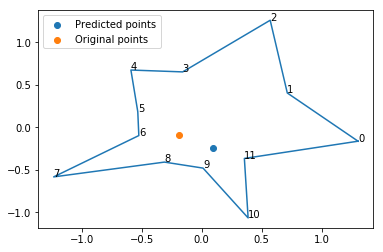

In [53]:
contour1=np.delete(polygons_reshaped[15],24)
contour1=contour1.reshape(12,2)
nb_of_inserted_points,inserted_point_coordinates=get_extrapoints_target_length(contour1,.4
                                                                              )
inserted_point_coordinates=np.array(inserted_point_coordinates)
my_conv_net.eval()
predictions=my_conv_net(x_variable).cpu()
predicted_inserted_points=predictions.data.numpy()[15]
predicted_inserted_points=predicted_inserted_points.reshape(1,2)
plt.scatter(predicted_inserted_points[:,0],predicted_inserted_points[:,1],label='Predicted points')
plt.scatter(inserted_point_coordinates[:,0],inserted_point_coordinates[:,1],label='Original points')

plot_contour(contour1)
plt.legend()

In [462]:
predicted_inserted_points

array([[ 0.09719837, -0.23911646]], dtype=float32)

In [747]:
d_tensor=torch.FloatTensor([2.2,1.2])
a_tensor=torch.FloatTensor([1,2])

In [748]:
d_variable=Variable(d_tensor)

a_variable=Variable(a_tensor)

In [749]:
d_variable.requires_grad=False
a_variable.requires_grad=True

In [750]:
fun=torch.sqrt((a_variable[0]-d_variable[0]).pow(2)+(a_variable[1]-d_variable[1]).pow(2))
fun

Variable containing:
 1.4422
[torch.FloatTensor of size 1]

In [692]:
fun.backward()

In [693]:
a_variable.grad

Variable containing:
-0.8321
 0.5547
[torch.FloatTensor of size 2]

In [694]:
a_variable.grad.zero_()

Variable containing:
 0
 0
[torch.FloatTensor of size 2]

In [812]:
from torch.autograd.function import Function
from math import pow

class myLossfunction(Function):
    
    @staticmethod
    def forward(self,output,target):
        self.save_for_backward(output,target) 

                        
       # output=output.view(int(output.size()[0]/2),2)

        #target=target.view(int(target.size()[0]/2),2)
        distance=torch.nn.PairwiseDistance()
        result=distance(output,target)

        result=torch.FloatTensor(result)
        #self.save_for_backward(result)


        return  result 
    
    
    @staticmethod
    def backward(self,grad_output1):
        input1,target=self.saved_variables
        
        print(input1)
        #distance=torch.nn.PairwiseDistance()(input1.view(int(input1.size()[0]/2),2),target.view(int(target.size()[0]/2),2))
        distance=torch.nn.PairwiseDistance()(input1,target)

        grad_output1=(input1-target)/distance

        
        return grad_output1,None
    

In [813]:
myloss=myLossfunction().apply(out,y_variable.narrow(0,b,batch_size).resize(batch_size,2))
myloss

Variable containing:
 0.2042
 0.4508
 0.6575
   ⋮    
 0.3220
 0.1622
 1.0774
[torch.FloatTensor of size 9721x1]

In [814]:
myloss.backward(torch.Tensor([1, 1]))


Variable containing:
-2.3953e-01 -1.6375e-01
-1.9727e-01 -3.8089e-01
-4.1456e-01 -9.3787e-02
           ⋮            
-7.2860e-02 -6.4023e-02
-1.8527e-01 -2.7595e-01
-2.6488e-01 -8.1565e-01
[torch.FloatTensor of size 9721x2]



In [754]:
a_variable.grad

Variable containing:
-0.8320  0.5547
[torch.FloatTensor of size 1x2]

In [634]:
myLossfunction.backward()

TypeError: backward() missing 2 required positional arguments: 'self' and 'grad_output1'

In [635]:
a_variable.grad

Variable containing:
 0
 0
[torch.FloatTensor of size 2]

In [636]:
# Flush all variables in GPU
del my_conv_net,my_net,x_variable_test,x_variable,y_variable,y_variable_test,loss_func
torch.cuda.empty_cache()


In [ ]:
point_coordinates

In [68]:
p2dust=torch.nn.PairwiseDistance(p=2)

In [69]:
p2dust(a_variable.resize(2,2),d_variable.resize(2,2))

Variable containing:
 1.4422
 2.2472
[torch.FloatTensor of size 2x1]

In [70]:
point_coordinates

array([[[ 0.09185446,  0.06111541]],

       [[ 0.09185446,  0.06111541]],

       [[ 0.09185446,  0.06111541]],

       ...,

       [[ 0.29833109, -0.19828089]],

       [[ 0.29833109, -0.19828089]],

       [[ 0.29833109, -0.19828089]]])

In [71]:
x_variable

Variable containing:
(  0   ,.,.) = 
  5.4394e-01 -1.2854e-01  1.2081e+00  ...   8.7166e-01 -3.9516e-01  4.0000e-01

(  1   ,.,.) = 
  8.0653e-01 -7.0666e-02  7.9998e-01  ...   1.0453e+00 -4.1684e-01  4.0000e-01

(  2   ,.,.) = 
  5.0649e-01  6.8832e-02  9.6722e-01  ...   8.5345e-01 -5.3134e-01  3.0000e-01
  ...  

(174975,.,.) = 
  1.1163e+00 -3.1378e-02  7.0993e-01  ...   7.3510e-01 -6.3782e-01  5.0000e-01

(174976,.,.) = 
  7.6960e-01 -4.1094e-02  7.8531e-01  ...   9.1110e-01 -3.1011e-01  9.0000e-01

(174977,.,.) = 
  1.2754e+00 -3.7225e-01  7.9667e-01  ...   5.6758e-01 -2.6036e-01  5.0000e-01
[torch.FloatTensor of size 174978x1x25]

In [ ]:
'''
Should I order the interior points ?

For each interior point calculate distance with points of the polygon

find which ti which point it is closer and sort it according to the index.

If multiple points are closer to the same point of the contour then take into

account the distance to the point.

'''

In [768]:
 output_reshaped=out.view(int(out.size()[0]/2),2)

RuntimeError: invalid argument 2: size '[4860 x 2]' is invalid for input with 19442 elements at C:\Anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\TH\THStorage.c:41

In [790]:
out,y_variable.narrow(0,b,batch_size).resize(batch_size,2)

(Variable containing:
 -1.4947e-01 -2.7472e-01
 -1.9165e-01 -2.2482e-01
 -1.3642e-01 -3.2461e-01
            ⋮            
 -3.8810e-02 -2.6062e-01
 -1.4880e-01 -2.9060e-01
 -1.3283e-01 -3.1349e-01
 [torch.FloatTensor of size 9721x2], Variable containing:
 -0.2311  0.0403
  0.1704 -0.1201
  0.2371 -0.1810
        ⋮        
 -0.0681  0.2579
 -0.1204 -0.1273
 -0.0528  0.2407
 [torch.FloatTensor of size 9721x2])

In [789]:
y_variable,out

(Variable containing:
 (  0   ,.,.) = 
  -0.2311  0.0403
 
 (  1   ,.,.) = 
   0.1704 -0.1201
 
 (  2   ,.,.) = 
   0.2371 -0.1810
   ...  
 
 (174975,.,.) = 
  -0.1804  0.0393
 
 (174976,.,.) = 
   0.2417  0.0188
 
 (174977,.,.) = 
   0.2496 -0.1190
 [torch.FloatTensor of size 174978x1x2], Variable containing:
 -1.4947e-01 -2.7472e-01
 -1.9165e-01 -2.2482e-01
 -1.3642e-01 -3.2461e-01
            ⋮            
 -3.8810e-02 -2.6062e-01
 -1.4880e-01 -2.9060e-01
 -1.3283e-01 -3.1349e-01
 [torch.FloatTensor of size 9721x2])

In [839]:
polygons[0][:,0].sum()/12

-1.0177044392397268e-16

In [826]:
def get_barycenters(polygons):
    
    for polygon 

SyntaxError: invalid syntax (<ipython-input-826-db58e474dc7f>, line 2)

In [864]:
polygons_reshaped[0][0::2].sum()

array([ 0.72589751,  0.84207899,  0.71337615,  0.16721335, -0.53593486,
       -1.19396456, -0.99666214, -0.86514855, -0.06646145,  0.05744332,
        0.52287723,  0.62928501])

In [865]:
polygons_reshaped[0][1::2]

array([ 0.17159901,  0.40510667,  0.63783057,  0.58156785,  0.85478697,
        0.50564378,  0.37817729, -0.73118862, -0.53079973, -1.1159677 ,
       -0.86178872, -0.29496737])

In [19]:
polygons_reshaped

array([[ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       [ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       [ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       ...,
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ],
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ],
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ]])

In [7]:
barycenters=[np.array([i[0::2].sum()/12,i[1::2].sum()/12]) for i in polygons_reshaped]

In [8]:
barycenters=np.array(barycenters)

In [12]:
len(point_coordinates)

218722

In [26]:
polygons_reshaped.shape

(218722, 24)

In [43]:
point_coordinates=point_coordinates.reshape(len(point_coordinates),2)

In [45]:
polygons_with_points=np.hstack([polygons_reshaped,point_coordinates])


In [48]:
polygons_with_points=polygons_with_points.reshape(len(polygons_with_points),13,2)

In [49]:
polygons_with_points

array([[[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       [[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       [[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       ...,

       [[ 0.94168403, -0.21109   ],
        [ 0.66819129,  0.35508194],
        [ 0.41427257,  0.62051448],
        ...,
        [ 0.46430839, -0.98049631],
        [ 0.94108807, -0.3414368 ],
        [ 0.29833109, -0.19828089]],

       [[ 0.94168403, -0.21109   ],
        [ 0.66819129,  0.35

In [52]:
polygons_with_points_unique=list(set(polygons_with_points))

TypeError: unhashable type: 'numpy.ndarray'

In [105]:
polygons_reshaped.shape

(60000, 2, 12)

In [68]:
centers_of_mass=np.array(centers_of_mass)


In [106]:
centers_of_mass.shape

(60000, 2)

In [107]:
x_variable

Variable containing:
(  0  ,.,.) = 
  1.0804e+00  3.6440e-01  6.1404e-01  ...   4.9729e-01 -1.0542e+00  8.4189e-01
 -1.1037e+00 -1.0409e-01 -5.6104e-01  ...  -1.1438e+00  7.8898e-01 -5.4535e-01

(  1  ,.,.) = 
  8.2030e-01 -9.6631e-02  1.1965e+00  ...   7.3245e-01 -1.1246e+00  6.5850e-01
 -9.8128e-01 -1.1748e-01 -4.0551e-01  ...  -7.3543e-01  5.2845e-01 -3.5533e-01

(  2  ,.,.) = 
  8.8570e-01 -9.5701e-02  1.2094e+00  ...   5.8753e-01 -7.4392e-01  6.8171e-01
 -1.2722e+00 -1.4492e-01 -1.0465e+00  ...  -5.5213e-01  6.8863e-01 -5.0008e-01
 ...  

(47997,.,.) = 
  1.0355e+00 -1.4388e-01  8.2466e-01  ...   7.1425e-01 -8.3453e-01  3.6346e-01
 -7.5888e-01  6.7694e-02 -8.8216e-01  ...  -1.0865e+00  3.7439e-01 -3.2188e-01

(47998,.,.) = 
  6.8633e-01  5.9241e-02  9.9623e-01  ...   1.1396e+00 -7.3713e-01  8.0244e-02
 -8.3097e-01 -2.3101e-01 -8.2566e-01  ...  -7.4034e-01  6.7384e-01 -5.5374e-01

(47999,.,.) = 
  8.7795e-01  6.0293e-02  8.4823e-01  ...   7.8716e-01 -7.3494e-01  3.3091e-01
 -1.1220

In [77]:
contour3=apply_procrustes(generate_contour(12))
plot_contour(contour3)

In [100]:
inserted_points=[]
nb_of_sampling=100
contour=contour3.copy()
plot_contour(contour3)

for i in range(0,nb_of_sampling):
    contour[0]=np.random.normal(contour3[0],0.08)
    contour[11]=np.random.normal(contour3[11],0.08)

    nb_of_points,point_coords=get_extrapoints_target_length(contour,0.2)
    inserted_points.append(point_coords)
    plt.scatter(contour[0][0],contour[0][1])
    plt.scatter(contour[11][0],contour[11][1])


inserted_points=[i for i in inserted_points if len(i)==1]
inserted_points=np.array(inserted_points)
inserted_points=inserted_points.reshape(len(inserted_points),2)

plt.scatter(inserted_points[:,0],inserted_points[:,1])

13 -0.1397529684620565 -0.03668817911622362 0
14 -0.5556838673885416 0.006489134426013973 0
13 -0.1506273310219623 -0.02890481750650344 0
14 -0.5584024580285181 0.008434974828444014 0
13 -0.1355795824036162 -0.0391512743253334 0
14 -0.5546405208739316 0.005873360623736529 0
13 -0.1606318248853285 -0.1507826396315696 0
13 -0.1029359385443222 -0.01988941712108101 0
14 -0.546479609909108 0.01068882492479963 0
13 -0.1469844471794247 -0.05733317507392088 0
14 0.7059926839926042 0.1405732385547066 0
15 -0.5574917370678837 0.001327885436589659 0
13 -0.06406265062238639 -0.0485721250445643 0
13 -0.1236015407066197 -0.04107046060343363 0
14 -0.5516460104496824 0.00539356405421147 0
13 -0.14404267783239 -0.03219865149111428 0
14 -0.556756294731125 0.00761151633229131 0
13 -0.1415910047281703 -0.02934662034552328 0
14 -0.5561433764550701 0.008324524118689058 0
13 -0.1393203257012531 -0.04295809812348142 0
14 -0.5555757066983406 0.004921654674199518 0
13 -0.05551841490555372 -0.04630404540602545 0

In [6]:
plot_contour(contour3)